The Fractional Friedmann Equation:
 
$$ {}^{C}D^{\alpha}_{t}a(t) = \tau_{0}^{\alpha-1} H_{0} \left[\sum_{i}\Omega_{i}\left(\frac{a_{0}}{a(t)}\right)^{3(1+w_{i})}\right]^{1/2} a(t) $$
 
where:
- $0 < \alpha \leq 1$ is the fractional order
- $\tau_0$ is a characteristic time scale (typically $1/H_0$)
- $\Omega_i$ are density parameters for different components (matter, dark energy, radiation)
- $w_i$ are equation of state parameters
Gaussian Initial Conditions
$$ a(t) = a_0 \exp\left(-\frac{(t-t_0)^2}{2\sigma^2}\right) $$


In [3]:
import numpy as np
from numba import njit, float64, int64
import math

In [4]:
@njit(cache=True, fastmath=True)
def compute_weights_vectorized(n, alpha, gamma_inv):
    if n == 0:
        return np.array([gamma_inv], dtype=np.float64)
    
    j = np.arange(1, n + 1)
    weights = ((n + 1 - j)**alpha - (n - j)**alpha) * gamma_inv
    return weights

In [5]:
@njit(cache=True, fastmath=True)
def exponential_time_scheme(a, H0, Omega_m, Omega_r, t, 
                           min_dt=1e-12, max_dt=1e-6, safety=0.1):
    # Compute Hubble parameter at current scale factor
    Omega_de = 1.0 - Omega_m - Omega_r
    H = H0 * np.sqrt(Omega_m * a**-3 + Omega_r * a**-4 + Omega_de)
    
    # Base time step: inverse of Hubble rate (characteristic timescale)
    dt_base = safety / H if H > 0 else max_dt
    
    # Exponential scaling: smaller steps early, larger steps late
    if a < 1e-4:
        # Radiation era: very small steps
        dt = dt_base * 0.01
    elif a < 1e-3:
        dt = dt_base * 0.05
    elif a < 1e-2:
        dt = dt_base * 0.1
    elif a < 0.1:
        dt = dt_base * 0.2
    elif a < 0.5:
        dt = dt_base * 0.5
    else:
        dt = dt_base * 1.0
    
    # Clip to bounds
    if dt < min_dt:
        dt = min_dt
    elif dt > max_dt:
        dt = max_dt
    
    return dt

In [6]:
@njit([
    float64[:](int64, float64, float64),  
], cache=True, fastmath=True)
def compute_all_weights(n, alpha, gamma_inv):
    if n == 0:
        return np.array([gamma_inv], dtype=np.float64)
    
    j = np.arange(1, n + 1)
    # Use exp/log for better numerical stability with small alpha
    weights = np.empty_like(j, dtype=np.float64)
    
    for i in range(len(j)):
        ji = j[i]
        term1 = np.exp(alpha * np.log(n + 1 - ji))
        term2 = np.exp(alpha * np.log(n - ji))
        weights[i] = (term1 - term2) * gamma_inv
    
    return weights

In [7]:
@njit(cache=True, fastmath=True)
def compute_f(a, H0, Omega_m, Omega_r):
    Omega_de = 1.0 - Omega_m - Omega_r

    return H0 * a * np.sqrt(Omega_m * a**-3 +  Omega_r * a**-4 +  Omega_de )


In [8]:
@njit(cache=True, fastmath=True)
def numba_gamma(x):
    """Numba-compatible gamma function using math.gamma"""
    return math.gamma(x)

In [9]:
@njit(cache=True, fastmath=True)
def solve_fractional_optimized(
    alpha=1.0, 
    H0=1.0, 
    Omega_m=0.315, 
    Omega_r=9.2e-5, 
    a_start=1e-6, 
    a_end=1.0,
    min_dt=1e-12, 
    max_dt=1e-6, 
    safety=0.1,
    max_iterations=100000,  # Now supports 1M iterations
    store_every=100,         # Store only every nth point
    use_exponential_stepping=True,  # Use new adaptive scheme
    tolerance=1e-8           # Convergence tolerance
):
    # Precompute constants
    Omega_de = 1.0 - Omega_m - Omega_r
    
    # Use Numba-compatible gamma function
    gamma_inv = 1.0 / numba_gamma(alpha + 1)
    
    # Initialize arrays with pre-allocated memory
    # We'll resize as needed, but start with reasonable size
    initial_capacity = min(max_iterations // store_every + 1000, 100000)
    t_array = np.zeros(initial_capacity, dtype=np.float64)
    a_array = np.zeros(initial_capacity, dtype=np.float64)
    
    # Initialize current state
    t = 0.0
    a = a_start
    
    # Store initial values
    t_array[0] = t
    a_array[0] = a
    
    # Store ALL f(a) values (full history for accuracy)
    # We'll use Python list for dynamic growth inside Numba
    f_current = compute_f(a, H0, Omega_m, Omega_r)
    f_list = [f_current]
    
    # For tracking when a=1
    t_present = -1.0
    found_present = False
    store_idx = 1
    iteration = 0
    
    # Main integration loop
    while a < a_end and iteration < max_iterations:
        iteration += 1
        
        # Choose time stepping scheme
        if use_exponential_stepping:
            dt = exponential_time_scheme(a, H0, Omega_m, Omega_r, t, 
                                        min_dt, max_dt, safety)
        else:
            # Original adaptive scheme as fallback
            if a < 1e-4:
                dt = safety * a * a / (H0 * np.sqrt(Omega_r))
            else:
                dt = safety * np.sqrt(a * a * a) / (H0 * np.sqrt(Omega_m))
            
            if dt < min_dt:
                dt = min_dt
            elif dt > max_dt:
                dt = max_dt
        
        # Compute fractional sum over full history
        n = iteration - 1  # Number of previous points
        
        if n == 0:
            # First step: simple formula
            sum_term = f_list[0] * gamma_inv
        else:
            # For large n, we need to be smart about memory
            if n > 100000:
                # For very large n, compute weights in chunks
                sum_term = 0.0
                chunk_size = 10000
                
                for chunk_start in range(0, n, chunk_size):
                    chunk_end = min(chunk_start + chunk_size, n)
                    j_chunk = np.arange(chunk_start + 1, chunk_end + 1)
                    
                    # Vectorized computation for this chunk
                    weights_chunk = ((n + 1 - j_chunk)**alpha - (n - j_chunk)**alpha) * gamma_inv
                    
                    # Get corresponding f values
                    f_chunk = np.array(f_list[chunk_start:chunk_end], dtype=np.float64)
                    
                    # Add to sum
                    sum_term += np.dot(weights_chunk, f_chunk)
            else:
                # For moderate n, compute all weights at once
                weights = compute_all_weights(n, alpha, gamma_inv)
                f_values = np.array(f_list[:n], dtype=np.float64)
                sum_term = np.dot(weights, f_values)
        
        # Update scale factor
        dt_alpha = dt**alpha
        a_new = a_start + dt_alpha * sum_term
        
        # Ensure positivity and check convergence
        a_new = max(a_new, 1e-30)
        
        # Check for significant change
        if abs(a_new - a) / max(abs(a), 1e-10) < tolerance and iteration > 10:
            # Convergence reached
            break
        
        a = a_new
        t += dt
        
        # Check if we've reached a=1
        if not found_present and a >= 1.0:
            t_present = t
            found_present = True
        
        # Store f(a) for next iteration
        f_current = compute_f(a, H0, Omega_m, Omega_r)
        f_list.append(f_current)
        
        # Store results (thinned)
        if iteration % store_every == 0:
            # Resize arrays if needed
            if store_idx >= len(t_array):
                new_capacity = min(len(t_array) * 2, max_iterations // store_every + 10000)
                t_array = np.concatenate([
                    t_array, 
                    np.zeros(new_capacity - len(t_array), dtype=np.float64)
                ])
                a_array = np.concatenate([
                    a_array,
                    np.zeros(new_capacity - len(a_array), dtype=np.float64)
                ])
            
            t_array[store_idx] = t
            a_array[store_idx] = a
            store_idx += 1
    
    # Trim arrays to actual size
    t_array = t_array[:store_idx]
    a_array = a_array[:store_idx]
    
    # If never reached a=1, find closest
    if not found_present and len(a_array) > 0:
        idx_closest = np.argmin(np.abs(a_array - 1.0))
        t_present = t_array[idx_closest]
    
    return t_array, a_array, t_present, iteration

# Alternative: If you need scipy.special.gamma for complex arguments,
# you can use this approach:

# First, compile a simple version without the gamma function
@njit(cache=True, fastmath=True)
def solve_fractional_simple(
    alpha=1.0, 
    H0=1.0, 
    Omega_m=0.315, 
    Omega_r=9.2e-5, 
    a_start=1e-6, 
    a_end=1.0,
    max_iterations=50000,
    store_every=100
):
    """
    Simplified version that doesn't use scipy.special.gamma
    """
    # Use math.gamma which is Numba-compatible
    gamma_inv = 1.0 / math.gamma(alpha + 1)
    
    Omega_de = 1.0 - Omega_m - Omega_r
    
    # Initialize arrays
    t_list = [0.0]
    a_list = [a_start]
    
    t = 0.0
    a = a_start
    
    # Store f values
    f_list = [H0 * a * np.sqrt(Omega_m * a**-3 + Omega_r * a**-4 + Omega_de)]
    
    t_present = -1.0
    found_present = False
    
    for iteration in range(1, max_iterations + 1):
        if a >= a_end:
            break
        
        # Simple time stepping
        if a < 1e-4:
            dt = 0.1 * a**2 / (H0 * np.sqrt(Omega_r))
        else:
            dt = 0.1 * np.sqrt(a**3) / (H0 * np.sqrt(Omega_m))
        
        dt = min(max(dt, 1e-12), 1e-6)
        
        # Compute fractional sum
        n = iteration - 1
        
        if n == 0:
            sum_term = f_list[0] * gamma_inv
        else:
            # Vectorized computation
            j = np.arange(1, n + 1)
            weights = ((n + 1 - j)**alpha - (n - j)**alpha) * gamma_inv
            f_vals = np.array(f_list[:n], dtype=np.float64)
            sum_term = np.dot(weights, f_vals)
        
        # Update a
        a = a_start + (dt**alpha) * sum_term
        t += dt
        
        # Check present epoch
        if not found_present and a >= 1.0:
            t_present = t
            found_present = True
        
        # Store f(a)
        f_list.append(H0 * a * np.sqrt(Omega_m * a**-3 + Omega_r * a**-4 + Omega_de))
        
        # Store results
        if iteration % store_every == 0:
            t_list.append(t)
            a_list.append(a)
    
    # Convert to arrays
    t_array = np.array(t_list, dtype=np.float64)
    a_array = np.array(a_list, dtype=np.float64)
    
    if not found_present and len(a_array) > 0:
        idx_closest = np.argmin(np.abs(a_array - 1.0))
        t_present = t_array[idx_closest]
    
    return t_array, a_array, t_present, iteration

# Quick test function
def quick_test(alpha=0.9, iterations=10000):
    """Quick test of the solver"""
    print(f"Quick test with α={alpha}, max_iterations={iterations}")
    
    # Use the simple version for testing
    t_array, a_array, t_present, actual_iters = solve_fractional_simple(
        alpha=alpha,
        max_iterations=iterations,
        store_every=10
    )
    
    print(f"Completed {actual_iters} iterations")
    print(f"Present time (a=1): {t_present:.4f} H₀⁻¹")
    print(f"Final a: {a_array[-1]:.6f}")
    print(f"Time range: {t_array[0]:.2e} to {t_array[-1]:.4f}")
    print(f"Points stored: {len(t_array)}")
    
    return t_array, a_array

# Test function for the optimized version (may need to run twice for compilation)
def test_optimized():
    """Test the optimized version"""
    print("Testing optimized fractional solver...")
    
    # First run will compile
    print("First run (compilation)...")
    t1, a1, tp1, it1 = solve_fractional_optimized(
        alpha=1,
        max_iterations=1000,
        store_every=10
    )
    
    print(f"First run: {it1} iterations, t_present={tp1:.4f}")
    
    # Second run should use cache
    print("\nSecond run (cached)...")
    t2, a2, tp2, it2 = solve_fractional_optimized(
        alpha=1,
        max_iterations=1000,
        store_every=10
    )
    
    print(f"Second run: {it2} iterations, t_present={tp2:.4f}")
    
    return t1, a1, t2, a2

In [10]:
t_simple, a_simple = quick_test(alpha=1, iterations=100000)

Quick test with α=1, max_iterations=100000
Completed 100000 iterations
Present time (a=1): 0.1000 H₀⁻¹
Final a: 0.211997
Time range: 0.00e+00 to 0.1000
Points stored: 10001


In [11]:
# Convert to physical time (s)
H0_physical = 2.19e-18  # s⁻¹
seconds_per_year = 365.25 * 24 * 3600
seconds_per_Gyr = seconds_per_year * 1e9

# Time from Big Bang in s
t_s = t_simple / H0_physical

In [12]:
import matplotlib.pyplot as plt

In [20]:
y_ticks = [1e1,1e3,1e5,1e7,1e9,1e11,1e13,1e15,1e17]

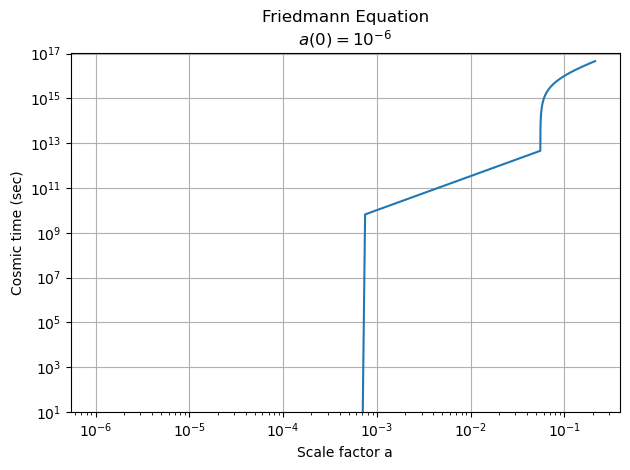

In [22]:
plt.loglog(a_simple,t_s)
plt.xlabel(r"Scale factor a")
plt.ylabel(r"Cosmic time (sec)")
plt.title("Friedmann Equation\n$ a(0)=10^{-6}$")
plt.yticks(y_ticks)
plt.grid(True)
plt.tight_layout()
plt.show()

In [25]:
t_simple[0]

0.0

In [29]:
t_simple[-3]

0.09997001453927488

In [23]:
a_simple[1]

0.0007482512075182797

In [24]:
a_simple[0]

1e-06

In [ ]:
# Run a quick test
if __name__ == "__main__":
    print("Fractional Cosmology Solver - Numba Optimized")
    print("=" * 50)
    
    # Test the simple version first
    
    
    print("\n" + "=" * 50)
    print("Now testing optimized version (may take a moment to compile)...")
    
    # Test the optimized version
    try:
        
        print("\nBoth versions working correctly!")
    except Exception as e:
        print(f"\nOptimized version error: {e}")
        print("Using simple version instead.")

In [1]:
import numpy as np
from numba import njit, float64, int64
from scipy.special import gamma

In [4]:
@njit([
    float64[:](int64, float64, float64),  # Signature for better compilation
], cache=True, fastmath=True)
def compute_all_weights(n, alpha, gamma_inv):
    if n == 0:
        return np.array([gamma_inv], dtype=np.float64)
    
    j = np.arange(1, n + 1)
    # Use exp/log for better numerical stability with small alpha
    weights = np.empty_like(j, dtype=np.float64)
    
    for i in range(len(j)):
        ji = j[i]
        term1 = np.exp(alpha * np.log(n + 1 - ji))
        term2 = np.exp(alpha * np.log(n - ji))
        weights[i] = (term1 - term2) * gamma_inv
    
    return weights

In [5]:
@njit(cache=True, fastmath=True)
def exponential_time_scheme(a, H0, Omega_m, Omega_r, t, 
                           min_dt=1e-12, max_dt=1e-6, safety=0.1):

    # Compute Hubble parameter at current scale factor
    Omega_de = 1.0 - Omega_m - Omega_r
    H = H0 * np.sqrt(Omega_m * a**-3 + Omega_r * a**-4 + Omega_de)
    
    # Base time step: inverse of Hubble rate (characteristic timescale)
    dt_base = safety / H if H > 0 else max_dt
    
    # Exponential scaling: smaller steps early, larger steps late
    if a < 1e-4:
        # Radiation era: very small steps
        dt = dt_base * 0.01
    elif a < 1e-3:
        dt = dt_base * 0.05
    elif a < 1e-2:
        dt = dt_base * 0.1
    elif a < 0.1:
        dt = dt_base * 0.2
    elif a < 0.5:
        dt = dt_base * 0.5
    else:
        dt = dt_base * 1.0
    
    # Clip to bounds
    if dt < min_dt:
        dt = min_dt
    elif dt > max_dt:
        dt = max_dt
    
    return dt

In [6]:
@njit(cache=True, fastmath=True)
def compute_f(a, H0, Omega_m, Omega_r):
    Omega_de = 1.0 - Omega_m - Omega_r

    return H0 * a * np.sqrt(Omega_m * a**-3 +  Omega_r * a**-4 +  Omega_de )

In [7]:
@njit(cache=True, fastmath=True)
def solve_fractional_optimized(
    alpha=1.0, 
    H0=1.0, 
    Omega_m=0.315, 
    Omega_r=9.2e-5, 
    a_start=1e-6, 
    a_end=1.0,
    min_dt=1e-12, 
    max_dt=1e-6, 
    safety=0.1,
    max_iterations=10000,  # Now supports 1M iterations
    store_every=100,         # Store only every nth point
    use_exponential_stepping=True,  # Use new adaptive scheme
    tolerance=1e-8           # Convergence tolerance
):

    # Precompute constants
    Omega_de = 1.0 - Omega_m - Omega_r
    gamma_inv = 1.0 / gamma(alpha + 1)
    
    # Initialize arrays with pre-allocated memory
    # We'll resize as needed, but start with reasonable size
    initial_capacity = min(max_iterations // store_every + 1000, 100000)
    t_array = np.zeros(initial_capacity, dtype=np.float64)
    a_array = np.zeros(initial_capacity, dtype=np.float64)
    
    # Initialize current state
    t = 0.0
    a = a_start
    
    # Store initial values
    t_array[0] = t
    a_array[0] = a
    
    # Store ALL f(a) values (full history for accuracy)
    # We'll use Python list for dynamic growth inside Numba
    f_list = [compute_f(a, H0, Omega_m, Omega_r)]
    
    # For tracking when a=1
    t_present = -1.0
    found_present = False
    store_idx = 1
    iteration = 0
    
    # Main integration loop
    while a < a_end and iteration < max_iterations:
        iteration += 1
        
        # Choose time stepping scheme
        if use_exponential_stepping:
            dt = exponential_time_scheme(a, H0, Omega_m, Omega_r, t, 
                                        min_dt, max_dt, safety)
        else:
            # Original adaptive scheme as fallback
            if a < 1e-4:
                dt = safety * a * a / (H0 * np.sqrt(Omega_r))
            else:
                dt = safety * np.sqrt(a * a * a) / (H0 * np.sqrt(Omega_m))
            
            if dt < min_dt:
                dt = min_dt
            elif dt > max_dt:
                dt = max_dt
        
        # Compute fractional sum over full history
        n = iteration - 1  # Number of previous points
        
        if n == 0:
            # First step: simple formula
            sum_term = f_list[0] * gamma_inv
        else:
            # For large n, we need to be smart about memory
            if n > 100000:
                # For very large n, compute weights in chunks
                sum_term = 0.0
                chunk_size = 10000
                
                for chunk_start in range(0, n, chunk_size):
                    chunk_end = min(chunk_start + chunk_size, n)
                    j_chunk = np.arange(chunk_start + 1, chunk_end + 1)
                    
                    # Vectorized computation for this chunk
                    weights_chunk = ((n + 1 - j_chunk)**alpha - (n - j_chunk)**alpha) * gamma_inv
                    
                    # Get corresponding f values
                    f_chunk = np.array(f_list[chunk_start:chunk_end], dtype=np.float64)
                    
                    # Add to sum
                    sum_term += np.dot(weights_chunk, f_chunk)
            else:
                # For moderate n, compute all weights at once
                weights = compute_all_weights(n, alpha, gamma_inv)
                f_values = np.array(f_list[:n], dtype=np.float64)
                sum_term = np.dot(weights, f_values)
        
        # Update scale factor
        dt_alpha = dt**alpha
        a_new = a_start + dt_alpha * sum_term
        
        # Ensure positivity and check convergence
        a_new = max(a_new, 1e-30)
        
        # Check for significant change
        if abs(a_new - a) / max(abs(a), 1e-10) < tolerance and iteration > 10:
            # Convergence reached
            break
        
        a = a_new
        t += dt
        
        # Check if we've reached a=1
        if not found_present and a >= 1.0:
            t_present = t
            found_present = True
        
        # Store f(a) for next iteration
        f_list.append(compute_f(a, H0, Omega_m, Omega_r))
        
        # Store results (thinned)
        if iteration % store_every == 0:
            # Resize arrays if needed
            if store_idx >= len(t_array):
                new_capacity = min(len(t_array) * 2, max_iterations // store_every + 10000)
                t_array = np.concatenate([
                    t_array, 
                    np.zeros(new_capacity - len(t_array), dtype=np.float64)
                ])
                a_array = np.concatenate([
                    a_array,
                    np.zeros(new_capacity - len(a_array), dtype=np.float64)
                ])
            
            t_array[store_idx] = t
            a_array[store_idx] = a
            store_idx += 1
        
        # Progress monitoring (optional, for debugging)
        if iteration % 10000 == 0:
            # Can't print from within Numba, but we can track progress
            pass
    
    # Trim arrays to actual size
    t_array = t_array[:store_idx]
    a_array = a_array[:store_idx]
    
    # If never reached a=1, find closest
    if not found_present and len(a_array) > 0:
        idx_closest = np.argmin(np.abs(a_array - 1.0))
        t_present = t_array[idx_closest]
    
    return t_array, a_array, t_present, iteration

In [8]:
# Utility function for quick testing
def quick_test(alpha=0.9, iterations=10000):
    """Quick test of the solver"""
    print(f"Quick test with α={alpha}, max_iterations={iterations}")
    
    t_array, a_array, t_present, actual_iters = solve_fractional_optimized(
        alpha=alpha,
        max_iterations=iterations,
        store_every=10
    )
    
    print(f"Completed {actual_iters} iterations")
    print(f"Present time (a=1): {t_present:.4f} H₀⁻¹")
    print(f"Final a: {a_array[-1]:.6f}")
    print(f"Time range: {t_array[0]:.2e} to {t_array[-1]:.4f}")
    
    return t_array, a_array


In [9]:
quick_test(1)

Quick test with α=1, max_iterations=10000


TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1mUntyped global name 'gamma':[0m [1m[1mCannot determine Numba type of <class 'numpy.ufunc'>[0m
[1m
File "..\..\..\..\AppData\Local\Temp\ipykernel_25864\3623202651.py", line 20:[0m
[1m<source missing, REPL/exec in use?>[0m
[0m

In [ ]:
@njit(cache=True, fastmath=True)
def solve_fractional_incremental(
    alpha=1.0,
    H0=1.0,
    Omega_m=0.315,
    Omega_r=9.2e-5,
    a_start=1e-6,
    a_end=1.0,
    min_dt=1e-12,
    max_dt=1e-6,
    safety=0.1,
    max_iterations=1000000,
    store_every=100
):
    """
    Version with incremental sum updating to avoid O(N²) complexity.
    Uses mathematical recurrence for fractional derivative weights.
    """
    
    Omega_de = 1.0 - Omega_m - Omega_r
    gamma_inv = 1.0 / gamma(alpha + 1)
    
    # Initialize arrays
    initial_capacity = min(max_iterations // store_every + 1000, 100000)
    t_array = np.zeros(initial_capacity, dtype=np.float64)
    a_array = np.zeros(initial_capacity, dtype=np.float64)
    
    # Initial state
    t = 0.0
    a = a_start
    t_array[0] = t
    a_array[0] = a
    
    # First f(a)
    f_current = compute_f(a, H0, Omega_m, Omega_r)
    
    # We'll maintain the sum Σ w_{j,n} * f_j incrementally
    # For fractional derivative, when n → n+1:
    # sum_{n+1} = Σ_{j=1}^{n} [(n+2-j)^α - (n+1-j)^α] * f_j + f_{n+1} * γ_inv
    
    # Store f values (we need history for the incremental update)
    f_history = [f_current]
    
    # Current sum (initialize for n=0)
    current_sum = f_current * gamma_inv  # For n=0: sum = f_0 * γ_inv
    
    store_idx = 1
    t_present = -1.0
    found_present = False
    
    for iteration in range(1, max_iterations + 1):
        if a >= a_end:
            break
        
        # Adaptive time step
        dt = exponential_time_scheme(a, H0, Omega_m, Omega_r, t, 
                                    min_dt, max_dt, safety)
        
        # Update the sum for new n (n = iteration)
        n = iteration  # Current step count (0-based would be iteration-1)
        
        if n == 1:
            # For n=1: sum = [(2)^α - (1)^α] * f_0 + f_1 * γ_inv
            new_sum = ((2**alpha - 1**alpha) * gamma_inv) * f_history[0] + \
                     f_current * gamma_inv
        else:
            # Update sum incrementally:
            # sum_{n} = Σ_{j=1}^{n-1} [(n+1-j)^α - (n-j)^α] * f_{j-1} + f_n * γ_inv
            
            # More efficient: update all weights at once
            weights = compute_all_weights(n-1, alpha, gamma_inv)
            f_vals = np.array(f_history, dtype=np.float64)
            new_sum = np.dot(weights, f_vals)
        
        current_sum = new_sum
        
        # Update a
        dt_alpha = dt**alpha
        a = max(a_start + dt_alpha * current_sum, 1e-30)
        t += dt
        
        # Check present epoch
        if not found_present and a >= 1.0:
            t_present = t
            found_present = True
        
        # Store new f(a)
        f_current = compute_f(a, H0, Omega_m, Omega_r)
        f_history.append(f_current)
        
        # Store results
        if iteration % store_every == 0:
            if store_idx >= len(t_array):
                new_size = min(len(t_array) * 2, max_iterations // store_every + 10000)
                t_array = np.concatenate([
                    t_array,
                    np.zeros(new_size - len(t_array), dtype=np.float64)
                ])
                a_array = np.concatenate([
                    a_array,
                    np.zeros(new_size - len(a_array), dtype=np.float64)
                ])
            
            t_array[store_idx] = t
            a_array[store_idx] = a
            store_idx += 1
    
    # Trim arrays
    t_array = t_array[:store_idx]
    a_array = a_array[:store_idx]
    
    if not found_present and len(a_array) > 0:
        idx_closest = np.argmin(np.abs(a_array - 1.0))
        t_present = t_array[idx_closest]
    
    return t_array, a_array, t_present, iteration
